# BNP Paribas Stock Price Neural Network Analysis

Below is a step-by-step Jupyter Notebook illustrating how to:
1. Load and clean BNP Paribas stock price data.
2. Compute log returns.
3. Prepare features and labels for a simple feedforward neural network.
4. Train the model to predict **next-day log returns** from the previous 5 days.
5. Evaluate on a small test set.
6. Perform an in-sample rolling prediction for the first 100 days.

Comments in each step clarify what’s happening.

## Step 1: Load Libraries and Read CSV

**What We Do**
1. Import pandas, NumPy, matplotlib, and math.
2. Read in the BNP Paribas CSV file (adjust the path as needed).
3. Convert the Date column to `datetime`, sort by Date, remove missing/invalid Close values.
4. Compute log prices, log returns, and drop any infinities/NaNs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Read BNP Paribas data (adjust the path to your CSV)
data_bnp = pd.read_csv('../data/BNPPA.csv')

# Convert 'Date' column to datetime
data_bnp['Date'] = pd.to_datetime(data_bnp['Date'])
data_bnp.sort_values('Date', inplace=True)
data_bnp.reset_index(drop=True, inplace=True)

# Remove missing or invalid Close values
data_bnp = data_bnp[data_bnp['Close'].notna()]
data_bnp = data_bnp[data_bnp['Close'] > 0]

# Compute log prices and log returns
data_bnp['LogClose'] = np.log(data_bnp['Close'])
data_bnp['LogRet']   = data_bnp['LogClose'].diff()

# Replace infinite values and drop NaNs
data_bnp.replace([np.inf, -np.inf], np.nan, inplace=True)
data_bnp.dropna(subset=['LogRet'], inplace=True)

# Inspect the first few rows of the cleaned DataFrame
data_bnp.head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogClose,LogRet
1,1993-10-19,21.129074,21.228039,20.832178,20.881660,3.838838,8760516.0,3.038871,-0.025732
2,1993-10-20,20.881660,21.129074,20.782696,21.030109,3.866129,6174815.0,3.045955,0.007084
3,1993-10-21,20.980625,21.376488,20.980625,21.376488,3.929806,8263391.0,3.062292,0.016336
4,1993-10-22,21.425970,21.970278,21.376488,21.871313,4.020774,10181091.0,3.085176,0.022884
5,1993-10-25,21.821831,22.019760,21.673384,21.920795,4.029871,4038109.0,3.087436,0.002260


## Step 2: Prepare Data for the Neural Network

**What We Do**
1. Extract the `LogRet` column as a NumPy array.
2. Define a window of size 5. For each day \( t \), the input features are the **previous 5** log returns, and the label is the **current** log return.
3. Append these to lists `X` and `y`, then convert to NumPy arrays.

In [3]:
logrets = data_bnp['LogRet'].values  # shape (N,)
window_size = 5
X, y = [], []

for i in range(window_size, len(logrets)):
    # The 5 previous returns (features)
    X.append(logrets[i - window_size:i])
    # The current day's return (label)
    y.append(logrets[i])

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)
print("Label shape:  ", y.shape)

Feature shape: (7499, 5)
Label shape:   (7499,)


## Step 3: (Optional) Train/Test Split

**What We Do**
1. Decide how many points to keep in the test set (e.g., last 100 days).
2. Slice `X` and `y` into `(X_train, y_train)` and `(X_test, y_test)`.

In [4]:
split_index = len(X) - 100
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set: ", X_test.shape, y_test.shape)

Training set: (7399, 5) (7399,)
Testing set:  (100, 5) (100,)


## Step 4: Build and Train a Simple Neural Network

**What We Do**
1. Install/import TensorFlow and Keras.
2. Define a basic feedforward network with:
   - Input layer size = 5 (one neuron per log-return in the window)
   - Hidden layer = 16 neurons (ReLU)
   - Output layer = 1 neuron (predicted next-day log return)
3. Compile with MSE loss and train on `(X_train, y_train)`.

/Users/mayeulboucher/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 5.5124e-04 - val_loss: 6.9922e-04
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 5.4006e-04 - val_loss: 6.9662e-04
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 5.1413e-04 - val_loss: 6.9790e-04
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 5.2385e-04 - val_loss: 7.0372e-04
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 5.4248e-04 - val_loss: 7.0046e-04
Epoch 6/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 4.8463e-04 - val_loss: 6.9990e-04
Epoch 7/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 5.0945e-04 - val_loss: 6.9827e-04
Epoch 8/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 5.1114e-04 - val_loss: 6.9660e-04
Epoch 9/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 5.5443e-04 - val_loss: 6.9860e-04
Epoch 10/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 5.2058e-04 - val_loss: 6.9691e-04
Epoch 11/20
209/209 ━━━━━━━━━━━━━━━━━━━

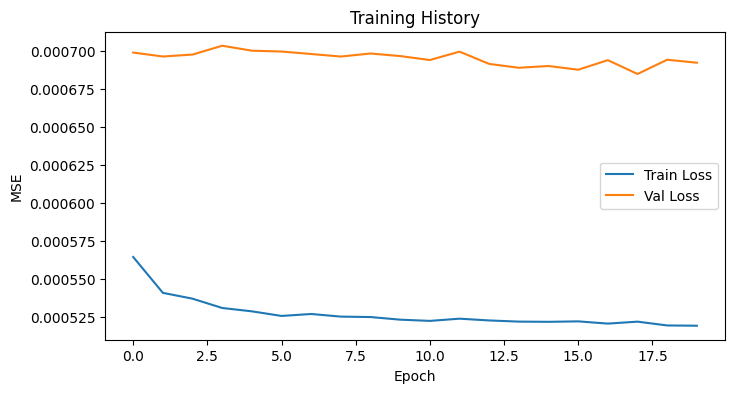

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model_nn = Sequential([
    Dense(16, activation='relu', input_shape=(window_size,)),
    Dense(1)
])

model_nn.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

model_nn.summary()

history = model_nn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Step 5: Evaluate on the Test Set

**What We Do**
1. Predict on `X_test`.
2. Calculate Mean Squared Error (MSE) vs. `y_test`.

In [6]:
pred_test = model_nn.predict(X_test).flatten()
mse_test = np.mean((pred_test - y_test)**2)
print("Test MSE on last 100 points:", mse_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test MSE on last 100 points: 0.00023933136387385812


## Step 6: In-Sample Rolling Prediction (First 100 Days)

**What We Do**
1. Use a "rolling" approach for the first 100 days:
   - For each day \( t \ge 5 \), feed the previous 5 actual returns to the model.
2. Convert the predicted log returns into a price path and compare against the actual price.

*Note*: This is just a demonstration of how the model fits in-sample, not a true out-of-sample test.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

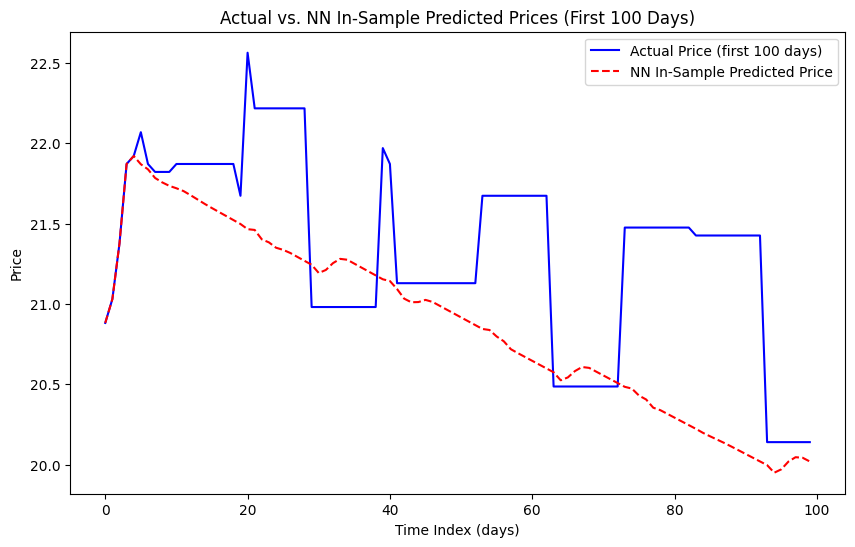

In [7]:
def rolling_prediction_in_sample(model, logrets, window_size=5, length=100):
    """
    In-sample rolling prediction for the first `length` days.
    For each day t >= window_size, use the actual log returns from [t - window_size..t-1]
    to predict logRet[t].
    """
    if length <= window_size:
        raise ValueError("length must be > window_size")

    predicted_returns = []
    for t in range(window_size, length):
        x_input = logrets[t - window_size:t].reshape(1, -1)
        pred = model.predict(x_input)[0, 0]
        predicted_returns.append(pred)

    return np.array(predicted_returns)

length_ = 100
logrets_array = data_bnp['LogRet'].values

# Generate rolling predictions for the first 100 days
preds_in_sample = rolling_prediction_in_sample(model_nn, logrets_array, window_size=5, length=length_)

# Actual closing prices for the first 100 days
actual_prices_100 = data_bnp['Close'].values[:length_]
pred_prices = [actual_prices_100[0]]

# For the first 5 days, replicate actual prices
for i in range(1, 5):
    pred_prices.append(actual_prices_100[i])

# From day 5..99, use predicted log returns to compute price
for i in range(5, length_):
    pred_logret = preds_in_sample[i - 5]
    next_price = pred_prices[-1] * np.exp(pred_logret)
    pred_prices.append(next_price)

pred_prices = np.array(pred_prices)

# Plot actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(range(length_), actual_prices_100, label='Actual Price (first 100 days)', color='blue')
plt.plot(range(length_), pred_prices, label='NN In-Sample Predicted Price', color='red', linestyle='--')
plt.title("Actual vs. NN In-Sample Predicted Prices (First 100 Days)")
plt.xlabel("Time Index (days)")
plt.ylabel("Price")
plt.legend()
plt.show()

## Step 7: Conclusion

**What We Did**
- Loaded BNP Paribas stock data and computed log returns.
- Prepared a 5-day rolling window of features to predict the next-day log return.
- Built a simple feedforward neural network with one hidden layer.
- Trained it on most of the data and tested on the last 100 data points.
- Demonstrated an in-sample rolling prediction for the first 100 days.

**Possible Extensions**
- Try a deeper network or an LSTM/GRU for more advanced time-series modeling.
- Adjust the window size (more or fewer days).
- Implement a walk-forward or rolling train/test methodology for a more realistic evaluation.